Source: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import os

In [66]:
df_src = pd.read_csv(pl.Path(os.path.abspath('')).parent.parent.resolve() / "data_files/processed_csv/summarized_corpus_valset2.csv")


In [78]:
df = df_src.copy()

In [80]:
df.head()

,id,domain,type,scraped_at,words,content_len,mean_word_len,median_word_len,split
0,34,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'headlin': 1, 'bitcoin': 1, 'blockchain': 2, ...",1574,5.381743,4.0,3
1,35,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'water': 2, 'cooler': 2, '<number><number><nu...",6647,5.081418,4.0,4
2,36,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'veteran': 2, 'comment': 8, 'call': 5, 'grow'...",3144,4.596525,4.0,7
3,37,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'lost': 6, 'word': 8, 'hidden': 3, 'bank': 4,...",3587,4.348983,4.0,8
4,39,beforeitsnews.com,fake,2018-01-25 16:17:44.789555,"{'scientist': 13, 'move': 11, 'doomsday': 19, ...",17970,5.380292,5.0,10


In [81]:
df.type.value_counts()

reliable    1530555
fake         715808
Name: type, dtype: int64

In [82]:
# remove duplicates by only keeping first occurence
df = df[df.duplicated(subset=["domain","type","scraped_at","words","content_len","mean_word_len"], keep='first') == False]

In [83]:
df = df.drop(["domain", "scraped_at"], axis = 1)

In [87]:
df.type.value_counts()

reliable    1525234
fake         619473
Name: type, dtype: int64

In [88]:
fake = "fake"
real = "reliable"
df = df[(df.type == fake) | (df.type == real)]
df.isnull().sum()

id                 0
type               0
words              0
content_len        0
mean_word_len      0
median_word_len    0
split              0
dtype: int64

In [89]:
# Shuffling
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis=1, inplace=True)

In [90]:
# df reduction to 200.000 articles; approx 1/10th
df2 = df[0:200000]

<Axes: xlabel='type', ylabel='count'>

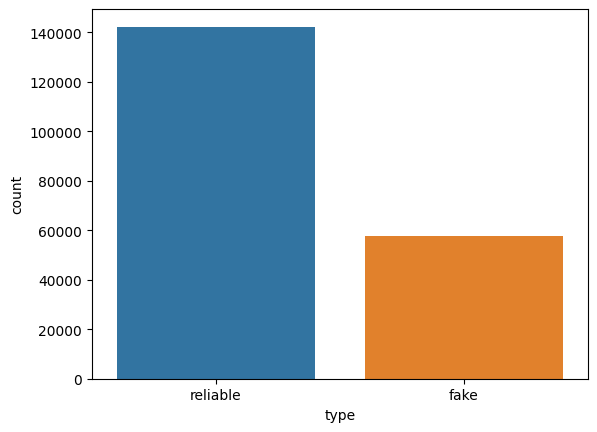

In [91]:
sns.countplot(data=df2,
              x='type',
              order=df2['type'].value_counts().index)

### Preprocessing and analysis of News column

In [147]:
df3 = df[0:100]
df3.head()
import ast
print(type(df3.words[0]))
df3['words'] = df3['words'].apply(ast.literal_eval)
print(type(df3.words[0]))

<class 'str'>
<class 'dict'>


C:\Users\45609\AppData\Local\Temp\ipykernel_16464\4064459196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['words'] = df3['words'].apply(ast.literal_eval)


In [140]:
# df2 = 200.000 rows; df3 = 2.000 rows
#transform 
import ast
df2['words'] = df2['words'].apply(ast.literal_eval)

In [106]:
# Use DictVectorizer to transform bag_of_words column
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()

D2 = df2['words'].tolist()
bag_of_words_matrix = vectorizer.fit_transform(D2)

In [90]:
bag_of_words_matrix

<200000x26928 sparse matrix of type '<class 'numpy.float64'>'
	with 34239228 stored elements in Compressed Sparse Row format>

In [108]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()
feature_names[4340:4360]

array(['birthright', 'biscayn', 'biscuit', 'bisexu', 'bishop', 'bison',
       'bistro', 'bit', 'bitch', 'bitcoin', 'bite', 'bitten', 'bitter',
       'bitterli', 'bittersweet', 'biweekli', 'biz', 'bizarr', 'bj',
       'bjork'], dtype=object)

In [81]:
# Convert matrix to dataframe
bag_of_words_df = pd.DataFrame.sparse.from_spmatrix(bag_of_words_matrix, columns=feature_names)

In [82]:
# Concatenate article_id column and bag_of_words_df
result = pd.concat([df2['id'],df2['type'],df2['content_len'], bag_of_words_df], axis=1)

In [83]:
result

,id,type,content_len,$$,$$1,$$10,$$100,$$10000,$$100000,$$11,...,zone,zoom,ztime,zucchini,zuckerberg,zuckerman,zynga,|,~,~~
0,4063736,fake,500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4787621,fake,844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9100231,reliable,1424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9648014,reliable,3406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8180359,reliable,484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,810114,fake,8277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,9028567,reliable,720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,9570131,reliable,624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,9257903,reliable,1555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
df3 = df2[0:2000]

### Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
  
x_train, x_test, y_train, y_test = train_test_split(df2['words'], 
                                                    df2['type'], 
                                                    test_size=0.25)

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = DictVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)  

#vectorization = TfidfVectorizer()
#x_train = vectorization.fit_transform(x_train)
#x_test = vectorization.transform(x_test)

### Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Logistic Regression and evaluate the prediction accuracy using accuracy_score.

In [119]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 10000)
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9938
0.9501


In [149]:
x_train.shape

(150000, 26927)

Let’s train with Decision Tree Classifier. 

In [114]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


1.0
0.93988


The confusion matrix for Decision Tree Classifier can be implemented with the code below.

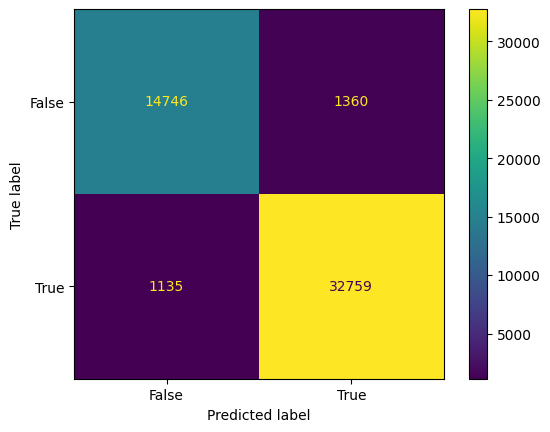

In [120]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

In [118]:
#Decision tree:

# 14480 | 1626
# ______|_______
#  1380 | 32514
#       |

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

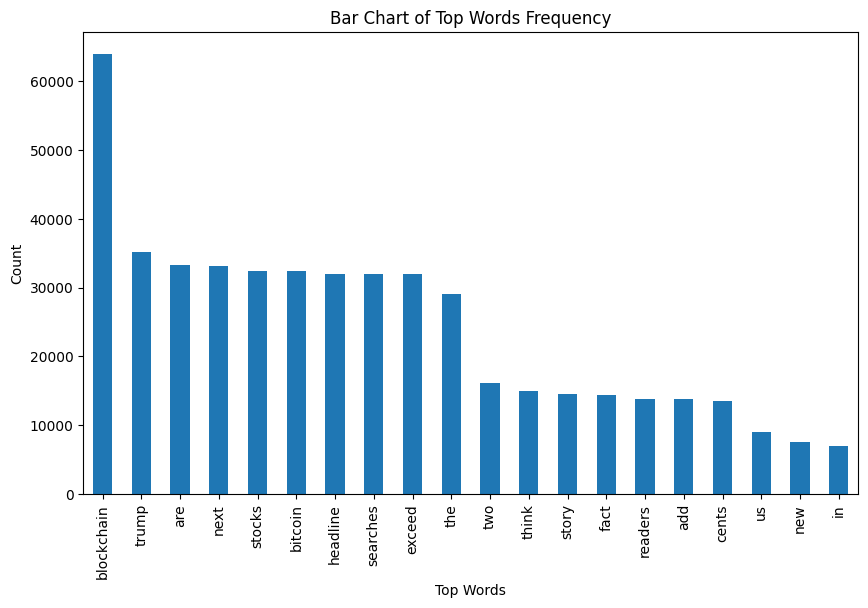

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(df[content], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)